In [95]:
from __future__ import print_function
import keras
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from keras import optimizers
import matplotlib.pylab as plt
import scipy.linalg
from sklearn.cluster import k_means
from sklearn.cluster import *
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import csv
import numpy as np
import pandas as pd
from imutils import paths
import random
import cv2
import os
import copy


In [102]:
batch_size = 128
epochs = 50
imsize = 128

# input image dimensions
img_x, img_y = imsize, imsize
input_shape = (img_x, img_y,3)
print(input_shape)

(128, 128, 3)


In [103]:
#ImageDataGenerator to generate batches of images
#add: zca_whitening = True,
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(imsize, imsize),
        batch_size=batch_size,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(imsize, imsize),
        batch_size=batch_size,
        class_mode='categorical')

Found 550 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [ ]:
num_classes = len(np.unique(train_datagen.classes))

In [104]:
train_generator.class_indices


{'10005': 0,
 '10026': 1,
 '10028': 2,
 '10033': 3,
 '10045': 4,
 '1005': 5,
 '10067': 6,
 '1031': 7,
 '1046': 8,
 '1054': 9}

In [105]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [106]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 124, 124, 32)      2432      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 53824)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               5382500   
_________________________________________________________________
dense_22 (Dense)             (None, 10)                1010      
Total para

In [107]:
model.fit_generator(train_generator,
          epochs=epochs,
          verbose=1,
          validation_data=validation_generator,
          )

Epoch 1/10
184/184 [==============================] - 65s 352ms/step - loss: 2.2781 - acc: 0.1359 - val_loss: 2.1935 - val_acc: 0.1900
Epoch 2/10
184/184 [==============================] - 64s 349ms/step - loss: 2.1311 - acc: 0.2373 - val_loss: 1.9456 - val_acc: 0.3400
Epoch 3/10
184/184 [==============================] - 63s 341ms/step - loss: 1.9480 - acc: 0.3442 - val_loss: 1.9407 - val_acc: 0.2600
Epoch 4/10
184/184 [==============================] - 64s 346ms/step - loss: 1.6997 - acc: 0.4167 - val_loss: 1.6275 - val_acc: 0.4400
Epoch 5/10
184/184 [==============================] - 61s 333ms/step - loss: 1.4808 - acc: 0.5000 - val_loss: 1.7145 - val_acc: 0.4600
Epoch 6/10
184/184 [==============================] - 63s 341ms/step - loss: 1.2973 - acc: 0.5996 - val_loss: 1.5894 - val_acc: 0.4800
Epoch 7/10
184/184 [==============================] - 65s 355ms/step - loss: 0.9206 - acc: 0.7083 - val_loss: 1.5761 - val_acc: 0.5100
Epoch 8/10
184/184 [==============================] - 6

In [108]:
y = train_generator.classes
yval = validation_generator.classes

yp = model.predict_generator(train_generator)
yp = [np.argmax(x) for x in yp]
ypval = model.predict_generator(validation_generator)
ypval = [np.argmax(x) for x in ypval]

In [109]:
df = pd.DataFrame([yval,ypval])
df = df.transpose()
df.columns =['t','p']

In [110]:
#modifying probabilities so that they sum up to 1
def softmax(ftr):
    print('compute softmax probabilities')
    num, dim = ftr.shape[0], ftr.shape[1]
    print('num %d dim %d' % (num, dim))
    prob = np.zeros((num, dim), dtype=np.single)
    for i in range(num):
        max_val = np.max(ftr[i, :])
        row = ftr[i, :] - max_val
        exp_val = np.exp(row)
        prob[i, :] = exp_val / np.sum(exp_val)
    return prob 

In [111]:
#TODO: automate
num_values = len(train_datagen.classes)

conf_mat = np.zeros((num_classes,num_classes))

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


In [112]:
'''
Hardcoding 100-class probabilities for validation images .
'''
#class_prob = [14/59,16/59,5/59,14/59,10/59]
class_prob = [0.1]*num_classes
val_prob = np.zeros((num_values,num_classes))

for i in range(num_values):
    for j in range(num_classes):
        val_prob[i][j]=class_prob[j]
val_prob=softmax(val_prob)
#print(val_prob)


compute softmax probabilities
num 100 dim 10


In [113]:
df.head()

,t,p
0,0,1
1,0,5
2,0,5
3,0,7
4,0,8


In [114]:
for i in range(df.shape[0]):
    t = df.loc[i]['t']
    p = df.loc[i]['p']
    #print(conf_mat)
    conf_mat[t][p] = conf_mat[t][p] +1
    #print(conf_mat)
for i in range(num_classes):
    conf_mat[i] = conf_mat[i]/sum(conf_mat[i])


[[0.1 0.1 0.  0.  0.  0.4 0.1 0.1 0.2 0. ]
 [0.  0.1 0.3 0.1 0.  0.2 0.  0.2 0.1 0. ]
 [0.1 0.  0.  0.  0.2 0.3 0.  0.2 0.1 0.1]
 [0.2 0.  0.  0.2 0.2 0.3 0.  0.1 0.  0. ]
 [0.3 0.  0.  0.1 0.1 0.4 0.  0.1 0.  0. ]
 [0.1 0.  0.  0.2 0.1 0.3 0.1 0.1 0.  0.1]
 [0.1 0.  0.  0.1 0.2 0.3 0.2 0.1 0.  0. ]
 [0.  0.  0.1 0.  0.2 0.3 0.2 0.1 0.1 0. ]
 [0.  0.2 0.  0.  0.3 0.2 0.1 0.  0.  0.2]
 [0.1 0.2 0.1 0.  0.1 0.3 0.1 0.  0.  0.1]]


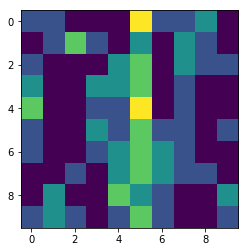

In [115]:
print(conf_mat)
plt.imshow(conf_mat)

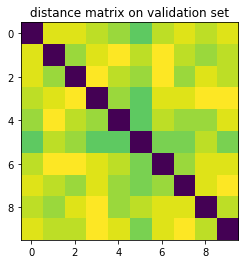

In [116]:
dist_mat = 1 - conf_mat
'''set diagonal elements to 0'''
dist_mat[range(num_classes),range(num_classes)]=0
dist_mat = 0.5 * (dist_mat + dist_mat.T)
plt.figure()
plt.title('distance matrix on validation set')
plt.imshow(dist_mat)

[-0.31622777 -0.31622777 -0.31622777 -0.31622777 -0.31622777 -0.31622777
 -0.31622777 -0.31622777 -0.31622777 -0.31622777]


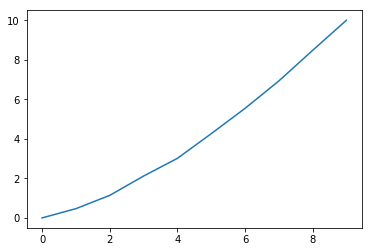

In [117]:
'''Laplacian eigenmap dimensionality reduction
construct adjacency graph W (symmetric) using k-NN'''
W=np.zeros((num_classes,num_classes))

#TODO: hyper-parameter optimization
k_nn, t, dim = 3, 0.9, 4

for i in range(num_classes):
    idx=np.argsort(dist_mat[i,:])[1:k_nn+1]
    W[i,idx]=np.exp(-dist_mat[i,idx] / t)
    W[idx,i]=W[i,idx]
D=np.zeros(W.shape)
for i in range(num_classes):
    D[i,i]=np.sum(W[i,:])
L=D-W
eig_val,eig_vec=scipy.linalg.eig(L,D)
ftr=eig_vec[:,1:dim+1]
print(eig_vec[:,0]) # the 1st eigenvector should be all ones
eigval_cumsum = np.cumsum(np.real(eig_val))
plt.plot(eigval_cumsum)

In [118]:
#TODO: hyperparameter optimization
affinity_propagation_cluster = AffinityPropagation(damping=0.75, max_iter=15000, convergence_iter=50, copy=True) 
cluster_labels = affinity_propagation_cluster.fit_predict(ftr)
unique_cluster_label = np.unique(cluster_labels)
n_cluster = unique_cluster_label.shape[0]
cluster_members=[None]*n_cluster
print ('%d clusters' % n_cluster)

2 clusters


In [119]:
label_names=range(num_classes)
for i in range(n_cluster):
    idx = np.nonzero(cluster_labels == unique_cluster_label[i])[0]
    cluster_members[i]=list(idx)
    print ('cluster %d size %d ' % (i, len(idx)))
    for j in range(len(idx)):
        print ('%s,' % label_names[idx[j]],)
    print (' ')
print(cluster_members)


cluster 0 size 3 
1,
8,
9,
 
cluster 1 size 7 
0,
2,
3,
4,
5,
6,
7,
 
[[1, 8, 9], [0, 2, 3, 4, 5, 6, 7]]


In [120]:
f2cmap = {}
for coarse in range(len(cluster_members)):
    for fine in cluster_members[coarse]:
        f2cmap[fine] = coarse


In [121]:
train_fine = train_generator.classes
train_coarse = [f2cmap[c] for c in train_fine]
val_fine = validation_generator.classes
val_coarse = [f2cmap[c] for c in val_fine]

In [122]:
# The number of coarse categories
coarse_categories = n_cluster
# The number of fine categories
fine_categories = num_classes

print(coarse_categories)
print(fine_categories)

# fine2coarse = np.zeros((fine_categories,coarse_categories))
# for i in range(coarse_categories):
#     for j in cluster_members[i]:
#         fine2coarse[j,i] = 1

2
10


In [123]:
#single classifier training (shared)
in_layer = Input(shape=input_shape, dtype='float32', name='main_input')

net = Conv2D(384, 3, strides=1, padding='same', activation='elu')(in_layer)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(384, 1, strides=1, padding='same', activation='elu')(net)
net = Conv2D(384, 2, strides=1, padding='same', activation='elu')(net)
net = Conv2D(640, 2, strides=1, padding='same', activation='elu')(net)
net = Conv2D(640, 2, strides=1, padding='same', activation='elu')(net)
net = Dropout(.2)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(640, 1, strides=1, padding='same', activation='elu')(net)
net = Conv2D(768, 2, strides=1, padding='same', activation='elu')(net)
net = Conv2D(768, 2, strides=1, padding='same', activation='elu')(net)
net = Conv2D(768, 2, strides=1, padding='same', activation='elu')(net)
net = Dropout(.3)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(768, 1, strides=1, padding='same', activation='elu')(net)
net = Conv2D(896, 2, strides=1, padding='same', activation='elu')(net)
net = Conv2D(896, 2, strides=1, padding='same', activation='elu')(net)
net = Dropout(.4)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(896, 3, strides=1, padding='same', activation='elu')(net)
net = Conv2D(1024, 2, strides=1, padding='same', activation='elu')(net)
net = Conv2D(1024, 2, strides=1, padding='same', activation='elu')(net)
net = Dropout(.5)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(1024, 1, strides=1, padding='same', activation='elu')(net)
net = Conv2D(1152, 2, strides=1, padding='same', activation='elu')(net)
net = Dropout(.6)(net)
net = MaxPooling2D((2, 2), padding='same')(net)

net = Flatten()(net)
net = Dense(1152, activation='elu')(net)
net = Dense(fine_categories, activation='softmax')(net)

In [124]:
model = Model(inputs=in_layer,outputs=net)
sgd_coarse = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer= sgd_coarse, loss='categorical_crossentropy', metrics=['accuracy'])

In [146]:

index= 0
step = 5
stop = 30

if not os.path.exists("data/models"):
        os.makedirs("data/models")
        
while index < stop:
    model.fit_generator(train_generator,
          epochs=index+step,
          verbose=1, initial_epoch=index,
          validation_data=validation_generator,
          )
    index += step
    model.save_weights('data/models/model_coarse'+str(index))

C:\Users\Devanshi\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
184/184 [==============================] - 2073s 11s/step - loss: 14.5121 - acc: 0.0996 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/2
184/184 [==============================] - 2206s 12s/step - loss: 14.5121 - acc: 0.0996 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/3
184/184 [==============================] - 2142s 12s/step - loss: 14.5121 - acc: 0.0996 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/4
184/184 [==============================] - 2418s 13s/step - loss: 14.5121 - acc: 0.0996 - val_loss: 14.5063 - val_acc: 0.1000


In [26]:
#model.load_weights('data/models/model_coarse'+str(1))

In [147]:
sgd_fine = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [148]:
for i in range(len(model.layers)):
    model.layers[i].trainable=False

In [149]:
#fine-tuning for coarse classifier
net = Conv2D(1024, 1, strides=1, padding='same', activation='elu')(model.layers[-8].output)
net = Conv2D(1152, 2, strides=1, padding='same', activation='elu')(net)
net = Dropout(.6)(net)
net = MaxPooling2D((2, 2), padding='same')(net)

net = Flatten()(net)
net = Dense(1152, activation='elu')(net)
out_coarse = Dense(coarse_categories, activation='softmax')(net)

model_c = Model(inputs=in_layer,outputs=out_coarse)
model_c.compile(optimizer= sgd_coarse, loss='categorical_crossentropy', metrics=['accuracy'])

for i in range(len(model_c.layers)-1):
    model_c.layers[i].set_weights(model.layers[i].get_weights())

In [150]:
#model_c.summary()

In [151]:
#generating directory structure for coarse categories
#we will have all fine categories as directories within each coarse category i.e most will be empty
print(train_generator.class_indices)
     
traindict = train_generator.class_indices
traindest = "data/ctrain"
trainsrc = "data/train"
valdict = validation_generator.class_indices
valdest = "data/cvalidation"
valsrc = "data/validation"

for c in range(coarse_categories):
    if not os.path.exists(traindest+"/"+str(c)):
        os.makedirs(traindest+"/"+str(c))
    if not os.path.exists(valdest+"/"+str(c)):
        os.makedirs(valdest+"/"+str(c))
    for key in traindict:
        if not os.path.exists(traindest+"/"+str(c)+"/"+key):
            os.makedirs(traindest+"/"+str(c)+"/"+key)
        if not os.path.exists(valdest+"/"+str(c)+"/"+key):
            os.makedirs(valdest+"/"+str(c)+"/"+key)

for key in traindict:
    val = traindict[key]
    c = f2cmap[val]
    os.system('cp '+ trainsrc+key +"/* "+ traindest+"/"+ str(c)+"/"+key)
    
for key in valdict:
    val = valdict[key]
    c = f2cmap[val]
    os.system('cp '+ valsrc+key +"/* "+ valdest+"/"+ str(c)+"/"+key)
        

{'10026': 1, '1031': 7, '10033': 3, '1005': 5, '10005': 0, '10028': 2, '10067': 6, '1054': 9, '1046': 8, '10045': 4}


In [152]:
ctrain_generator = train_datagen.flow_from_directory(
        'data/ctrain',
        target_size=(imsize, imsize),
        batch_size=batch_size,
        class_mode='categorical')
cvalidation_generator = test_datagen.flow_from_directory(
        'data/cvalidation',
        target_size=(imsize, imsize),
        batch_size=batch_size,
        class_mode='categorical')

Found 550 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [153]:
index = 30
step = 5
stop = 50

while index < stop:
    model_c.fit_generator(ctrain_generator,
          epochs=index+step,
          verbose=1, initial_epoch=index,
          validation_data = cvalidation_generator
          )
    index += step

Epoch 5/5
184/184 [==============================] - 1204s 7s/step - loss: 11.2420 - acc: 0.3025 - val_loss: 11.2827 - val_acc: 0.3000
Epoch 6/6
184/184 [==============================] - 1178s 6s/step - loss: 11.3001 - acc: 0.2989 - val_loss: 11.2827 - val_acc: 0.3000
Epoch 7/7
184/184 [==============================] - 1252s 7s/step - loss: 11.3001 - acc: 0.2989 - val_loss: 11.2827 - val_acc: 0.3000


In [160]:
model_c.compile(optimizer=sgd_fine, loss='categorical_crossentropy', metrics=['accuracy'])
stop = 80

while index < stop:
    model_c.fit_generator(ctrain_generator,
          epochs=index+step,
          verbose=1, initial_epoch=index,
          validation_data = cvalidation_generator
          )
    index += step

Epoch 8/8
184/184 [==============================] - 925s 5s/step - loss: 11.2420 - acc: 0.3025 - val_loss: 11.2827 - val_acc: 0.3000
Epoch 9/9
184/184 [==============================] - 798s 4s/step - loss: 11.3001 - acc: 0.2989 - val_loss: 11.2827 - val_acc: 0.3000
Epoch 10/10
184/184 [==============================] - 844s 5s/step - loss: 11.3001 - acc: 0.2989 - val_loss: 11.2827 - val_acc: 0.3000


Variables:
y, yval, yp, ypval : true and predicted labels for train and validation
train_coarse, train_fine, val_coarse,val_fine : coarse and fine labels for train and validation

In [161]:
#constructing fine classifiers
def fine_model():
    net = Conv2D(1024, 1, strides=1, padding='same', activation='elu')(model.layers[-8].output)
    net = Conv2D(1152, 2, strides=1, padding='same', activation='elu')(net)
    net = Dropout(.6)(net)
    net = MaxPooling2D((2, 2), padding='same')(net)

    net = Flatten()(net)
    net = Dense(1152, activation='elu')(net)
    out_fine = Dense(fine_categories, activation='softmax')(net)
    model_fine = Model(inputs=in_layer,outputs=out_fine)
    model_fine.compile(optimizer= sgd_coarse,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    for i in range(len(model_fine.layers)-1):
        model_fine.layers[i].set_weights(model.layers[i].get_weights())
    return model_fine

In [162]:
fine_models = {'models' : [{} for i in range(coarse_categories)], 'yhf' : [{} for i in range(coarse_categories)]}
for i in range(coarse_categories):
    model_i = fine_model()
    fine_models['models'][i] = model_i

In [163]:
def get_error(y,yh):
    # Threshold 
    yht = np.zeros(np.shape(yh))
    #here, 1 denotes axis=column
    yht[np.arange(len(yh)), yh.argmax(1)] = 1
    # Evaluate Error
    error = np.count_nonzero(np.count_nonzero(y-yht,1))/len(y)
    return error

In [164]:
#creating generators for fine classifiers
traingenlist = []
valgenlist = []
for i in range(coarse_categories):
    tgen = train_datagen.flow_from_directory(
            'data/ctrain/'+str(i),
            target_size=(imsize, imsize),
            batch_size=batch_size,
            class_mode='categorical')
    vgen = test_datagen.flow_from_directory(
            'data/cvalidation/'+str(i),
            target_size=(imsize, imsize),
            batch_size=batch_size,
            class_mode='categorical')
    traingenlist.append(tgen)
    valgenlist.append(vgen)

Found 165 images belonging to 10 classes.
Found 30 images belonging to 10 classes.
Found 385 images belonging to 10 classes.
Found 70 images belonging to 10 classes.


In [165]:
#training fine classifiers on corresponding data
for cat in range(coarse_categories):
    index= 0
    step = 5
    stop = 30
    
    # Get all training data for the coarse category (not needed as we have generators)
    ix = [i for i,j in f2cmap.items() if j==cat]
    print(ix)
    
    while index < stop:
        fine_models['models'][cat].fit_generator(traingenlist[cat],
          epochs=index+step,
          verbose=1, initial_epoch=index,
          validation_data = valgenlist[cat]
          )
        index += step
    
    fine_models['models'][cat].compile(optimizer=sgd_fine, loss='categorical_crossentropy', metrics=['accuracy'])
    stop = 50

    while index < stop:
        fine_models['models'][cat].fit_generator(traingenlist[cat],
          epochs=index+step,
          verbose=1, initial_epoch=index,
          validation_data = valgenlist[cat]
          )
        index += step
        
    #check: compilation needed??
    
    yh_f = fine_models['models'][cat].predict_generator(valgenlist[cat],steps=30)
    print('Fine Classifier '+str(cat)+' Error: ')
    #str(get_error(y_val[ix_v],yh_f)))
    

[1, 8, 9]
Epoch 1/5
55/55 [==============================] - 232s 4s/step - loss: 11.8199 - acc: 0.2667 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 2/5
55/55 [==============================] - 245s 4s/step - loss: 10.7454 - acc: 0.3333 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 3/5
55/55 [==============================] - 234s 4s/step - loss: 10.7454 - acc: 0.3333 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 4/5
55/55 [==============================] - 236s 4s/step - loss: 10.7454 - acc: 0.3333 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 5/5
55/55 [==============================] - 236s 4s/step - loss: 10.7454 - acc: 0.3333 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 6/10
55/55 [==============================] - 235s 4s/step - loss: 10.7454 - acc: 0.3333 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 7/10
55/55 [==============================] - 246s 4s/step - loss: 10.7454 - acc: 0.3333 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 8/10
55/55 [==============================] - 256s 5s/step

In [193]:
#yh_f

In [190]:
#Probabilistic averaging
#predictions from coarse classifier
#coarse_predictions dim: n_images_predict X n_classes_coarse

coarse_predictions=model_c.predict_generator(validation_generator,steps=30)
#coarse_predictions=model_c.predict(img)
#predictions from #(coarse categories) fine classifiers
fine_predictions = [] #dim:  n_classes_coarse X n_images_predict X n_classes_fine
for c in range(coarse_categories):
    fine_predictions.append(fine_models['models'][c].predict_generator(validation_generator,steps=30))
    #fine_predictions.append(fine_models['models'][c].predict(img))


In [184]:
coarse_predictions

array([[1., 0.]], dtype=float32)

In [185]:
fine_predictions

[array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)]

In [186]:
prediction_size = len(coarse_predictions)
predictions = []
for img in range(prediction_size):
    proba = [0]*fine_categories
    for finec in range(fine_categories):
        for coarsec in range(coarse_categories):
            proba[finec] += coarse_predictions[img][coarsec]*fine_predictions[coarsec][img][finec]
    predicted = np.argmax(proba)
    predictions.append(predicted)